## Info

This is a testing notebook for the MM Estimator in R.

Its stems from there being issues in what version of R is installed relative to Python, Anaconda and rpy2.

<font color=red size=4> **Its important to test multiple environments (kernels) here!** </font>
- fnb
- test


It uses the Boston Data Set from sklearn as test data.

<font color='purple' size=4>**This is another MM Estimator but using MASS as a suggestion from Elke rather tham LMROB.**</font>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sma

import os
import gc

pd.set_option('max_columns', 150)
pd.set_option('max_rows', 100)

### Import Data and Elastic Net

In [2]:
import sklearn.datasets

In [3]:
boston = sklearn.datasets.load_boston()
X = pd.DataFrame(boston.data, columns=boston.feature_names)
y = pd.DataFrame(boston.target, columns=['target'])

In [4]:
X.head()

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  
0     15.3  396.90   4.98  
1     17.8  396.90   9.14  
2     17.8  392.83   4.03  
3     18.7  394.63   2.94  
4     18.7  396.90   5.33

In [5]:
y.head()

target
0    24.0
1    21.6
2    34.7
3    33.4
4    36.2

### Installing R in Python

1. Open an Anaconda Prompt and run: **conda install -c r r-base**
2. Install: **conda install -c r r-mass**
3. Install: **conda install -c r r-robustbase**
4. Install: **pip install rpy2** 
    - (do not do this with Conda, only pip !)

### Set up R Home

In [6]:
import os
##  you must then set your R HOME before importing the module - it should be in a similar location as below

# os.environ['R_HOME'] = 'C:/Users/schillw/Anaconda3/envs/test/Lib/R'
os.environ['R_HOME'] = 'C:/Users/schillw/Anaconda3/envs/fnb/Lib/R'


In [7]:
from rpy2.robjects import r
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from rpy2 import robjects
import rpy2
pandas2ri.activate()

import sys
print("Python version should be 3.7.9.")
print("Current Python Version: {}".format(sys.version))
print("rpy2 Version = ", rpy2.__version__)

print("\nR VERSION = ", r.version)

Python version should be 3.7.9.
Current Python Version: 3.7.9 (default, Aug 31 2020, 17:10:11) [MSC v.1916 64 bit (AMD64)]
rpy2 Version =  3.4.5

R VERSION =                 _                           
platform       x86_64-w64-mingw32          
arch           x86_64                      
os             mingw32                     
system         x86_64, mingw32             
status                                     
major          3                           
minor          6.3                         
year           2020                        
month          02                          
day            29                          
svn rev        77875                       
language       R                           
version.string R version 3.6.3 (2020-02-29)
nickname       Holding the Windsock        



### Import R Packages as Python Packages with rpy2

In [8]:
mass = importr('MASS')
rstats = importr('stats')
robustbase = importr('robustbase')
rbase = importr('base')
sfs = importr('sfsmisc')

C:\Users\schillw\Anaconda3\envs\fnb\lib\site-packages\rpy2\robjects\vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '


### Create a DataFrame

In [9]:
## create a dataframe like you do for SAS OUT and standardize (the model didnt like unstandardized data)
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
xs = pd.DataFrame(ss.fit_transform(X), columns=X.columns)
ys = pd.Series(ss.fit_transform(y).flatten()); ys.name='target'

rdf = pd.concat([y,xs], axis=1)
rdf.head()

target      CRIM        ZN     INDUS      CHAS       NOX        RM  \
0    24.0 -0.419782  0.284830 -1.287909 -0.272599 -0.144217  0.413672   
1    21.6 -0.417339 -0.487722 -0.593381 -0.272599 -0.740262  0.194274   
2    34.7 -0.417342 -0.487722 -0.593381 -0.272599 -0.740262  1.282714   
3    33.4 -0.416750 -0.487722 -1.306878 -0.272599 -0.835284  1.016303   
4    36.2 -0.412482 -0.487722 -1.306878 -0.272599 -0.835284  1.228577   

        AGE       DIS       RAD       TAX   PTRATIO         B     LSTAT  
0 -0.120013  0.140214 -0.982843 -0.666608 -1.459000  0.441052 -1.075562  
1  0.367166  0.557160 -0.867883 -0.987329 -0.303094  0.441052 -0.492439  
2 -0.265812  0.557160 -0.867883 -0.987329 -0.303094  0.396427 -1.208727  
3 -0.809889  1.077737 -0.752922 -1.106115  0.113032  0.416163 -1.361517  
4 -0.511180  1.077737 -0.752922 -1.106115  0.113032  0.441052 -1.026501

### Model Based on Formula

In [10]:
y_name = y.name if type(y)==pd.core.series.Series else y.columns[0]
print(y_name)

target


In [11]:
rdf.to_csv('boston_test_data.csv')

### OLD

In [91]:
## tukey defaults are S=1.55, M=4.69
cntrl_str = '''psi="bisquare", maxiter=1000, estimator="MM", tuning.chi=1.55, tuning.psi=4.69'''

# cntrl_str = '''psi="huber", maxiter=1000, estimator="MM", tuning.chi=1.55, tuning.psi=1.345'''

cntrl = robjects.r('a1 <- lmrob.control({})'.format(cntrl_str)) 

# model = robustbase.lmrob('{} ~ .'.format(y_name), data=rdf, estimator="MM", 
#                          psi="bisquare", maxiter=1000, tuning_chi=1.55, tuning_psi=4.69) # control=cntrl)

## they are a tiny bit different

model = robustbase.lmrob('{} ~ .'.format(y_name), data=rdf, estimator="MM", control=cntrl)

model_coefs = rbase.summary(model).rx2('coefficients')

# print(np.round(model_coefs,3))
print(type(model_coefs))

<class 'numpy.ndarray'>


In [92]:
pd.DataFrame(model_coefs, columns=['coeff','a','b','c'],
             index = ['Intercept'] + list(X.columns)).round(3)

coeff      a        b      c
Intercept  21.699  0.212  102.574  0.000
CRIM       -1.078  0.397   -2.714  0.007
ZN          0.638  0.337    1.893  0.059
INDUS      -0.096  0.234   -0.411  0.682
CHAS        0.313  0.152    2.066  0.039
NOX        -0.709  0.387   -1.831  0.068
RM          4.334  1.026    4.223  0.000
AGE        -1.172  0.418   -2.806  0.005
DIS        -2.008  0.373   -5.383  0.000
RAD         1.319  0.459    2.874  0.004
TAX        -1.874  0.407   -4.604  0.000
PTRATIO    -1.506  0.184   -8.166  0.000
B           1.141  0.268    4.253  0.000
LSTAT      -1.555  0.686   -2.267  0.024

### NEW

- there is no way to test against this huber estimation as it appears that SAS only can run TUKEY and YOHAI
- so it should have said TUKEY in the program not HUBER - 2022-03-09
- repaired 2022-03-10 after conversations with Jeff Stokes
    - the version in production is working but better to never use HUber again

In [123]:
mass.psi_huber

<rpy2.robjects.functions.DocumentedSTFunction object at 0x00000272B6B21EC8> [RTYPES.CLOSXP]
R classes: ('function',)

In [112]:
form = '{} ~ {}'.format(y_name, ' + '.join([c for c in xs.columns]))
print(form)

# cntrl_str2 = '''psi="bisquare", maxiter=1000, estimator="MM", tuning.chi=1.55, tuning.psi=4.69'''
# cntrl2 = robjects.r('a1 <- mass.control({})'.format(cntrl_str)) 


psi = "psi.bisquare"
method = "MM"
model2 = mass.rlm_formula(form, data=rdf, method=method, 
                          k2 = 4.685,
#                           psi = "psi.bisquare(u, c = 4.685, deriv = 0)", 
#                           psi = "psi.bisquare(u, c = 3.44, deriv = 0)", 
#                           psi=psi, #(c=4.685)", 
                          psi=mass.psi_huber,
#                           psi = "psi.huber",
#                           scale_est = scale_est,
                          maxit=1000)
model2.scale_est = psi
model2.method = method
model2_coefs = rbase.summary(model2).rx2('coefficients')

# print(model2_coefs)

target ~ CRIM + ZN + INDUS + CHAS + NOX + RM + AGE + DIS + RAD + TAX + PTRATIO + B + LSTAT


In [113]:
pd.DataFrame(model2_coefs, columns=['coeff','a','b',],
             index = ['Intercept'] + list(X.columns)).round(3)

coeff      a        b
Intercept  21.699  0.149  145.495
CRIM       -1.077  0.200   -5.395
ZN          0.639  0.226    2.824
INDUS      -0.096  0.298   -0.323
CHAS        0.313  0.155    2.026
NOX        -0.710  0.313   -2.270
RM          4.333  0.207   20.892
AGE        -1.172  0.263   -4.463
DIS        -2.008  0.297   -6.770
RAD         1.320  0.408    3.234
TAX        -1.874  0.448   -4.186
PTRATIO    -1.506  0.200   -7.530
B           1.141  0.173    6.589
LSTAT      -1.555  0.256   -6.081

In [114]:
# model2.items

In [115]:
model2.scale_est

'psi.bisquare'

In [116]:
model2.method

'MM'

In [117]:
# summ = rbase.summary(model2)
# print(summ)
## junk thing prints a bunhc of crap

In [118]:
print(model2.names)

 [1] "coefficients"  "residuals"     "wresid"        "effects"      
 [5] "rank"          "fitted.values" "assign"        "qr"           
 [9] "df.residual"   "w"             "s"             "psi"          
[13] "k2"            "weights"       "conv"          "converged"    
[17] "x"             "call"          "terms"         "xlevels"      
[21] "model"        



In [119]:
model2.rx2['k2']

array([4.685])

In [120]:
model2.rx2['psi']

<rpy2.robjects.functions.SignatureTranslatedFunction object at 0x00000272BF216688> [RTYPES.CLOSXP]
R classes: ('function',)

In [89]:
# for item in model2.names:
#     print(item, model2.rx[item][:100])

In [107]:
rstats.vcov(model2)

array([[ 2.22403344e-02, -2.54733309e-17,  1.04215306e-16,
         2.93601212e-16,  1.70158495e-17, -1.39434072e-16,
         5.25816849e-16, -3.55350120e-17, -2.19947644e-17,
        -1.93470277e-16, -1.61692453e-16,  4.11826644e-16,
        -2.33445008e-16,  2.48667455e-16],
       [-2.54733309e-17,  3.98589393e-02, -3.93443802e-03,
         2.20737379e-03,  1.54381882e-03,  3.72056843e-03,
         1.09004657e-03, -1.75156573e-04,  6.91757421e-03,
        -2.17446365e-02,  1.05898722e-03,  8.36514291e-04,
         4.05945906e-03, -7.79763323e-03],
       [ 1.04215306e-16, -3.93443802e-03,  5.11251505e-02,
         7.16429978e-03, -5.15924849e-04,  2.52955346e-03,
        -7.30550646e-03,  7.16461880e-03, -2.70064980e-02,
         9.76170728e-03, -2.25894452e-02,  1.40739306e-02,
        -4.46789038e-04, -3.07272770e-03],
       [ 2.93601212e-16,  2.20737379e-03,  7.16429978e-03,
         8.87744390e-02, -4.74319805e-03, -2.45859010e-02,
         5.68038219e-03, -8.62198324e-05,  1.

In [108]:
# for item in model2.names: #['rank','df.residual','effects','assign','w','s','psi','k2','converged']: #,'model']:
#     print(item)
#     print(model.rx2(item))

**FROM ELKE EMAIL**

*I do think that LmRob  does something weird with the covariance estimation, I can’t quite figure out what, but I am not sure it is right.  You can also do MM estimation in R using rlm from MASS and there you have a lot more control over stuff (I just saw that).  If I just use the default with one little adjustment (using Huber estimate for scale instead of MAD – which only makes a very slight difference) I can pretty much match SAS exactly (this is for Other Loans):*

In [109]:
# form = '{} ~ {}'.format(y_name, ' + '.join([c for c in xs.columns]))
# print(form)

# model2 = mass.rlm_formula(form, data=rdf, method="MM", scale_est='Huber', maxiter=1000)
# model2_coefs = rbase.summary(model2).rx2('coefficients')

# print(model2_coefs)

In [110]:
idx = ['(Intercept)'] + list(xs.columns)
m2c = pd.DataFrame(rbase.summary(model2).rx2('coefficients'), index=idx, 
                   columns=['Value', 'Std. Error', 't value'])

pvals = []
for v in idx: #xs.columns:
    ftest = sfs.f_robftest(model2, var = v) # "CRIM")
    # print(ftest.names)
#     for item in ["statistic","df",#"method",
#                  "alternative","null.value","p.value"]: #ftest.names:
#         print(v, item, ftest.rx2(item))
    pvals.append([v,np.round(ftest.rx2('p.value')[0],4)])
#     print('\n')
pval = pd.DataFrame(pvals, columns=['var_name','pval']).set_index('var_name')

m2c['pval'] = pval
# m2c

In [111]:
from statsmodels.iolib import SimpleTable
from statsmodels.iolib.tableformatting import (gen_fmt, fmt_2, fmt_params)
from statsmodels.iolib.summary import forg

In [112]:
SimpleTable(m2c.values)

<class 'statsmodels.iolib.table.SimpleTable'>

In [113]:
def r_summary_model2(model, X):
    """ Create a dict with information about the model """
    import datetime as dt
    from statsmodels.iolib import SimpleTable
    from statsmodels.iolib.tableformatting import (gen_fmt, fmt_2, fmt_params)
    from statsmodels.iolib.summary import forg
#         model = self.model

    info = {}
    info['Model:'] = 'R Robust Estimator - MASS'
    info['Date:'] = dt.datetime.now().strftime('%Y-%m-%d %H:%M')
    info['Estimator / Function:'] = str(model.scale_est)+' / '+str(model.method)
    info['Chi:'] = str(model.rx2('k2')[0])
    info['Psi:'] = str(model2.rx2['psi'])[:34]
    info['No. Observations:'] = len(model.rx2('x'))
    info['Df Model:'] = rbase.summary(model).rx2('df')[0]
    info['Df Residuals:'] = len(model.rx2('x')) - rbase.summary(model).rx2('df')[0] #model.rx2('df.residual')[0]
    info['Converged:'] = model.rx2('converged')[0]
#     info['Iters:'] = rbase.summary(model).rx2('iter')#[0]
    info['Scale Est.:'] = np.round(model.rx2('s')[0],5)
#     info['Adj. R-squared:'] = np.round(rbase.summary(model).rx2('adj.r.squared')[0],5)

    ## fitted values
    ## resids and whitened resids

    out = pd.DataFrame(info, index=range(len(info))).T.iloc[:,0]
    model_coefs = rbase.summary(model).rx2('coefficients')
    orig_data = model.rx2('model')
    var_names = ['(Intercept)'] + list(X.columns) #self.X.columns)

    model_data = list(info.items())
    mt = SimpleTable(model_data, txt_fmt=fmt_params)
    
    pvals = []
    for v in var_names:
        ftest = sfs.f_robftest(model2, var = v) # "CRIM")
        pvals.append([v,np.round(ftest.rx2('p.value')[0],4)])
    pval = pd.DataFrame(pvals, columns=['var_name','pval']).set_index('var_name')
    
    m2c = pd.DataFrame(rbase.summary(model2).rx2('coefficients'), index=var_names, 
                       columns=['Value', 'Std. Error', 't value'])
    
    m2c['pvals'] = pval

    params_data = []
    for i in range(m2c.shape[0]):
        curr_row = m2c.values[i,:]
#         params_data.append([forg(j, prec=4) for j in curr_row])
        params_data.append([np.round(j,5) for j in curr_row])
#     params_data
    pt = SimpleTable(params_data, ['Estimate', 'Std. Error', 't value', 'Pr(>|t|)'],
                     var_names, txt_fmt=fmt_params)
    return mt, pt

In [114]:
for item in r_summary_model2(model2, xs):
    print(item)

               Model:          R Robust Estimator - MASS
                Date:                   2022-03-09 16:10
Estimator / Function:                         Huber / MM
                 Chi:                              1.345
                 Psi: function (u, c = 4.685, deriv = 0)
    No. Observations:                                506
            Df Model:                                 14
        Df Residuals:                                492
           Converged:                              False
          Scale Est.:                            2.86531
              Estimate Std. Error    t value   Pr(>|t|)
-------------------------------------------------------
(Intercept)   21.69909    0.14913  145.50262        0.0
CRIM          -1.07629    0.19965   -5.39098        0.0
ZN              0.6395    0.22611    2.82829     0.0056
INDUS          -0.0966    0.29795   -0.32423     0.7417
CHAS           0.31311    0.15455    2.02591     0.0539
NOX           -0.71064     0.3126   -2

In [115]:
def r_summary_model(model, X):
    """ Create a dict with information about the model """
    import datetime as dt
    from statsmodels.iolib import SimpleTable
    from statsmodels.iolib.tableformatting import (gen_fmt, fmt_2, fmt_params)
    from statsmodels.iolib.summary import forg
#         model = self.model

    info = {}
    info['Model:'] = 'R Robust Estimator'
    info['Date:'] = dt.datetime.now().strftime('%Y-%m-%d %H:%M')
    info['Estimator / Function:'] = str(model.rx2('control').rx2('estimator')[0])+' / '+str(model.rx2('control').rx2('psi')[0])
    info['Chi / Psi :'] = str(model.rx2('control').rx2('tuning.chi')[0])+' / '+str(model.rx2('control').rx2('tuning.psi')[0])
    info['No. Observations:'] = len(model.rx2('x'))
    info['Df Model:'] = rbase.summary(model).rx2('df')[0]
    info['Df Residuals:'] = model.rx2('df.residual')[0]
    info['Converged:'] = rbase.summary(model).rx2('converged')[0]
    info['Iters:'] = rbase.summary(model).rx2('iter')[0]
    info['Scale Est.:'] = np.round(rbase.summary(model).rx2('scale')[0],5)
    info['Adj. R-squared:'] = np.round(rbase.summary(model).rx2('adj.r.squared')[0],5)

    out = pd.DataFrame(info, index=range(len(info))).T.iloc[:,0]
    model_coefs = rbase.summary(model).rx2('coefficients')
    orig_data = model.rx2('model')
    var_names = ['Intercept'] + list(X.columns) #self.X.columns)

    model_data = list(info.items())
    mt = SimpleTable(model_data, txt_fmt=fmt_params)

    params_data = []
    for i in range(model_coefs.shape[0]):
        curr_row = model_coefs[i,:]
#         params_data.append([forg(j, prec=4) for j in curr_row])
        params_data.append([np.round(j,5) for j in curr_row])
    pt = SimpleTable(params_data, ['Estimate', 'Std. Error', 't value', 'Pr(>|t|)'],
                     var_names, txt_fmt=fmt_params)
    return mt, pt

In [116]:
for item in r_summary_model(model, X):
    print(item)

               Model: R Robust Estimator
                Date:   2022-03-09 16:10
Estimator / Function:      MM / bisquare
          Chi / Psi :        1.55 / 4.69
    No. Observations:                506
            Df Model:                 14
        Df Residuals:                492
           Converged:               True
               Iters:                 46
          Scale Est.:            2.86151
      Adj. R-squared:            0.83702
             Estimate Std. Error    t value   Pr(>|t|)
------------------------------------------------------
Intercept    21.69937    0.21115  102.76877        0.0
CRIM         -1.07767    0.39662   -2.71713    0.00682
ZN            0.63829    0.33715    1.89322    0.05891
INDUS        -0.09617    0.23416   -0.41071    0.68146
CHAS          0.31314    0.15164    2.06496    0.03945
NOX          -0.70911    0.38719   -1.83142    0.06764
RM            4.33405      1.026    4.22421      3e-05
AGE          -1.17244    0.41799   -2.80494    0.00523

In [117]:
rbase.summary(model).rx2('coefficients')[:,2]

array([102.76876975,  -2.71712842,   1.89322413,  -0.41071462,
         2.06495645,  -1.83141528,   4.22421229,  -2.80493828,
        -5.37510323,   2.87502413,  -4.60402788,  -8.17565677,
         4.24491705,  -2.26739344])

In [118]:
co_mod = robustbase.lmrob('{} ~ 1'.format(y_name), data=rdf, estimator="MM", control=cntrl)
rbase.summary(co_mod).rx2('coefficients')
# robjects.r.predict(co_mod)

array([[2.09146176e+001, 3.62915239e-001, 5.76294830e+001,
        3.26697850e-224]])

In [ ]:
def robust_stats(model, y, yhat):
    '''Specific to the Robust Model'''
    
#     y = fit.model.endog
    cntrl_str = '''psi="bisquare", maxiter=1000, estimator="MM", tuning.chi=1.55, tuning.psi=4.69'''
    cntrl = robjects.r('a1 <- lmrob.control({})'.format(cntrl_str)) 

    co_mod = robustbase.lmrob('{} ~ 1'.format(y_name), data=rdf, estimator="MM", control=cntrl)
    cm_coefs = rbase.summary(co_mod).rx2('coefficients')
    co_pred = robjects.r.predict(co_mod)
    
    rmse = np.sqrt(mean_squared_error(y, model.rx2('fitted.values')))
    co_rmse = np.sqrt(mean_squared_error(y, co_pred))
    
    print("="*92)
    print("Model RMSE = {:.5f},   ConstOnly RMSE = {:.5f}".format(rmse, co_rmse))
    if rmse < co_rmse:
        print("The model is a lift over the constant only model.")
    else:
        print("The model is not a lift over the constant only model.")
    print("="*92)

    print("model scale = {:.5f}".format(model.scale))
    ar2 = model.adj_r2
    print("pseudo r^2 = {:.5f}".format(ar2))
    print("="*92)

    out1 = pd.DataFrame(np.array([[fit.scale], [ar2]]).reshape(1,2), index=['Stats'], columns=['Scale','Adj R Square'])
    out2 = pd.DataFrame(np.array([[rmse], [co_rmse], ['True' if rmse < co_rmse else 'False']]).reshape(1,3), index=['Lift over Null'], columns=['RMSE','Null RMSE','Null > Model'])
    return out1, out2, co_mod

In [44]:
def predict(model, X=None):
    '''predict call
       X does not have to be a dataframe but must have same shape as
       the orignal enxog (no constant)
    '''
    if X is None:
        return self.insample_pred
    else:
        return robjects.r.predict(model, X)

In [45]:
pred = predict(model, xs)

In [46]:
import statsmodels.api as sma

In [29]:
rlm = sma.RLM(endog=y, exog=sma.add_constant(xs)).fit(maxiter=1000, tol=1e-12)
rlmp = pd.DataFrame(rlm.predict(), index=y.index, columns=['rlm'])
print(rlm.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                 target   No. Observations:                  506
Model:                            RLM   Df Residuals:                      492
Method:                          IRLS   Df Model:                           13
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Fri, 05 Feb 2021                                         
Time:                        16:28:29                                         
No. Iterations:                    45                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.9300      0.155    141.712      0.0

In [31]:
rlm.

const      2.008232e+04
CRIM       1.926789e+01
ZN         1.221952e+01
INDUS      6.203261e-07
CHAS       6.486508e+00
NOX        1.368991e+01
RM         2.719674e+02
AGE        5.816612e+00
DIS        5.710552e+01
RAD        1.616960e+01
TAX        1.646598e+01
PTRATIO    6.473380e+01
B          3.119287e+01
LSTAT      8.439971e+01
dtype: float64

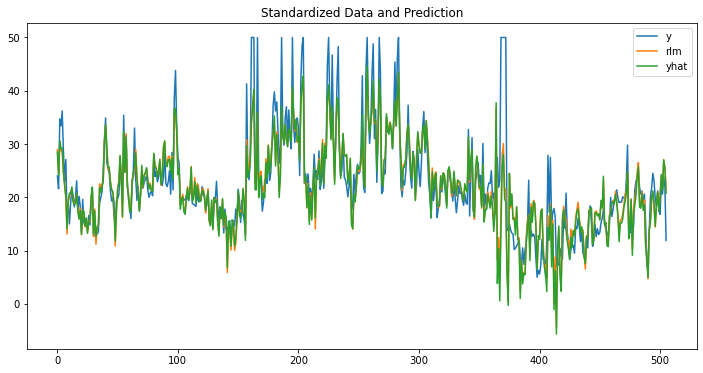

In [48]:
fig, ax=plt.subplots(1,1,figsize=(12,6))
y.plot(ax=ax);
rlmp.plot(ax=ax);
ax.plot(pred);
ax.legend(['y','rlm','yhat']);
ax.set_title("Standardized Data and Prediction");